In [1]:
# get_ipython().run_line_magic('matplotlib','notebook')
# # get_ipython().run_line_magic('matplotlib','inline')
# get_ipython().run_line_magic('load_ext','autoreload')
# get_ipython().run_line_magic('autoreload','2')

%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/channel_soufflet_lev41/'
save_path = '/albedo/home/pscholz/tripyview/Results/test_newploting/'
save_fname= None

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/home/pscholz/results/test_channel_ctrl_01/1/')
input_paths.append('/albedo/home/pscholz/results/test_channel_spltexpl_BTstep50_BTtheta0.14/1/')

input_names= list()
input_names.append('ssh channel')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
year      = [1958, 1958]
mon, day, record, box, depth = None, None, -1, None, 1000

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None #
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979, 2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
do_clim   = False
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = False, 0.995

ref_cstr, ref_cnum = 'wbgyr', 15
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
proj              = 'channel'
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            = False  # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, cyclic=4.5, do_info=True, do_pickle=False, 
                          do_loadraw=False, do_lsmask=False)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)  
        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > load mesh from *.out files: /albedo/work/user/pscholz/mesh_fesom2.0/channel_soufflet_lev41
 > comp e_area
 > comp n_area
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/channel_soufflet_lev41
 > id              = channel_soufflet_lev41
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = False
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 2875
 > #elem           = 5700
 > #lvls           = 41
___________________________________________


0 /albedo/home/pscholz/results/test_channel_spltexpl_BTstep50_BTtheta0.14/1/ ssh channel
channel [0.0, 4.5, 0.0, 17.9049]


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


cmin, cmax =  -0.5485156178474426 0.5462614297866821
{'cstr': 'blue2red', 'cnum': 20, 'chist': False, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -0.55, 'cmax': 0.55, 'cref': 0.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x1550fafe4c40>, 'clevel': array([-0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ]), 'clab': array([-0.45, -0.3 , -0.15,  0.  ,  0.15,  0.3 ,  0.45,  0.6 ])}
 > save figure: /albedo/home/pscholz/tripyview/Results/test_newploting/ssh_channel_channel_y1958-1958_rec_-1.png


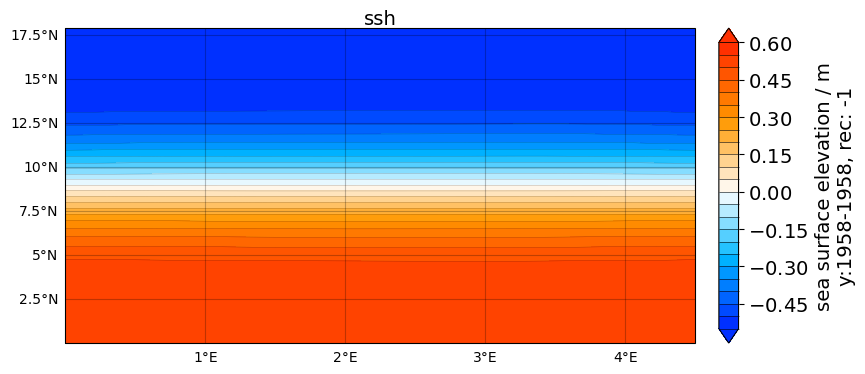

In [5]:
vname     = 'ssh'
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=depth, descript=vname, do_info=False, do_file='run', do_parallel=False) 
    #__________________________________________________________________________________________________    
    data_list.append(data)  
    del(data)

#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
ncol0  = np.min([ncol,len(data_list)])    
nrow0  = np.ceil(len(data_list)/ncol0).astype('int')
ndat   = len(data_list)

svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
#______________________________________________________________________________________________________
# do save filename path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_channel_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

0 /albedo/home/pscholz/results/test_channel_spltexpl_BTstep50_BTtheta0.14/1/ ssh channel
channel [0.0, 4.5, 0.0, 17.9049]


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


cmin, cmax =  15.562507065087635 22.228192682311242
{'cstr': 'cmocean.thermal', 'cnum': 20, 'chist': False, 'ctresh': 0.995, 'cnlab': 8, 'cmin': 15.56, 'cmax': 22.23, 'cref': 20.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x155550777ee0>, 'clevel': array([15.5 , 15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 ,
       17.75, 18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75,
       20.  , 20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  ,
       22.25]), 'clab': array([16., 17., 18., 19., 20., 21., 22.])}
 > save figure: /albedo/home/pscholz/tripyview/Results/test_newploting/temp_channel_channel_y1958-1958_rec_-1_dep10m.png


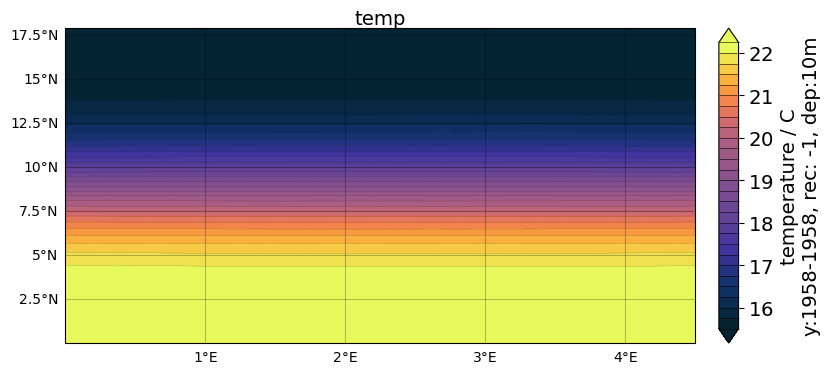

In [6]:
vname     = 'temp'
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=10, descript=vname, do_info=False, do_file='run') 
    #__________________________________________________________________________________________________    
    data_list.append(data)  
    del(data)

#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
ncol0  = np.min([ncol,len(data_list)])    
nrow0  = np.ceil(len(data_list)/ncol0).astype('int')
ndat   = len(data_list)

svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
#______________________________________________________________________________________________________
# do save filename path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_channel_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
cinfo0.update({'cstr':'cmocean.thermal'})    

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

## Make Channel movie:
save each frame as *.png than ...

ffmpeg -pattern_type glob -r 1 -i 'frame_*.png' -c:v libx264 -pix_fmt yuv420p -vf scale=1440:992 movie.mp4  <br>
ffmpeg -i movie.mp4 -r 6 -filter:v "setpts=PTS/6" movie_x6.mp4<br>
ffmpeg -stream_loop 5 -i movie_x6.mp4 -c copy movie_x6_loop5.mp4


channel [0.0, 4.5, 0.0, 17.9049]


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


{'cstr': 'cmocean.balance', 'crange': [-1.0, 1.0, 0], 'cnum': 40, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.0, 'cmax': 1.0, 'cref': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x1550faa720a0>, 'clevel': array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  0.95,  1.  ]), 'clab': array([-0.9, -0.6, -0.3,  0. ,  0.3,  0.6,  0.9])}


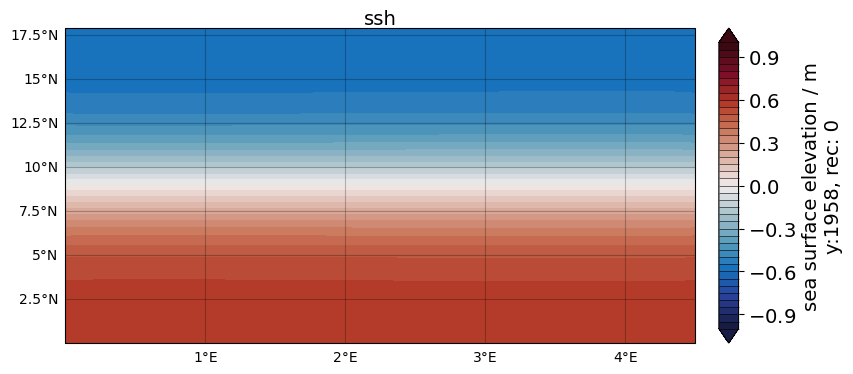

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


IndexError: Index 31 is out of bounds for axis 0 with size 31

In [8]:
import matplotlib.pyplot        as plt
import time
vname     = 'ssh'
data_list = list()
year      = [1958, 1958]
record    = [0, 365]#[0, 221]
save_path = '/albedo/home/pscholz/tripyview/Results/check_channel/movie/'
do_plt   = 'tcf'
which_dpi = 300

#___LOAD FESOM2 DATA___________________________________________________________________________________
cnt = 0
for yeari in range(year[0], year[1]+1):
    for reci in range(record[0], record[1]):
        
        #______________________________________________________________________________________________
        data = tpv.load_data_fesom2(mesh, input_paths[0], vname=vname, year=yeari, mon=mon, day=day, record=reci, 
                                    depth=None, descript=vname, do_info=False) 

        #___PLOT FESOM2 DATA___________________________________________________________________________
        cinfo0 = dict({'cstr':'cmocean.balance', 'crange':[-1.0, 1.0, 0], 'cnum':40})
        spath  = os.path.join(save_path,'{}_{:04d}_{:04d}.png'.format('frame', yeari, reci))

        #______________________________________________________________________________________________
        if cnt==0 :
            fig, hax, hcb, hall, tri, cinfo_plot = tpv.plot_hslice(mesh, [data], cinfo=cinfo0, box=None, nrow=1, ncol=1, proj=proj, do_rescale=False,  
                                                                do_plt=do_plt, plt_contb=False, plt_contf=False, plt_contr=False, plt_contl=False, do_enum=False, 
                                                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                                                do_save=None, nargout=['hfig', 'hax', 'hcb', 'hall', 'tri', 'cinfo_plot'])  
            tpv.do_savefigure(spath, fig, dpi=save_dpi, do_info=False)    
        
        #______________________________________________________________________________________________
        else:
            data_plot = data['ssh'].values.copy()
            data_plot = np.hstack((data_plot,data_plot[mesh.n_pbnd_a]))
            hall[0].remove()
            hall = []
            if do_plt=='tcp':
                hp=hax[ii].tripcolor(tri.x, tri.y, tri.triangles[tri.mask_e_ok,:], data_plot,
                                     shading='flat', cmap=cinfout['cmap'],
                                     vmin=cinfo_plot[0]['clevel'][0], vmax=cinfo_plot[0]['clevel'][ -1],)
            elif do_plt=='tcf': 
                hp=hax[ii].tricontourf(tri.x, tri.y, tri.triangles[tri.mask_e_ok,:], data_plot,
                                       levels=cinfo_plot[0]['clevel'], cmap=cinfo_plot[0]['cmap'], extend='both',)
            
            hall.append(hp)
                                
            hax[0].set_title('year: {:4d}, day: {:03d}'.format(yeari, reci+1), fontsize=14)
            fig.canvas.draw()
            fig.canvas.flush_events()
            tpv.do_savefigure(spath, fig, dpi=which_dpi, do_info=False) 
            
        cnt = cnt+1
        print(cnt)